## Unsupervised ML

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Data loading

In [2]:
df = pd.read_csv('../data Cleaned/housing_trees.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

,longitude,latitude,housing_median_age,median_income,median_house_value,ocean_proximity,rooms_per_bedroom,population_per_household,bedroom_per_household,room_per_household
0,-122.23,37.88,41.0,8.3252,452600.0,2,6,2,1,6
1,-122.22,37.86,21.0,8.3014,358500.0,2,6,2,0,6
2,-122.24,37.85,52.0,7.2574,352100.0,2,7,2,1,8
3,-122.25,37.85,52.0,5.6431,341300.0,2,5,2,1,5
4,-122.25,37.85,52.0,3.8462,342200.0,2,5,2,1,6


In [3]:
corr = df.corr()['median_house_value'].sort_values(ascending = False)
print(corr)

median_house_value          1.000000
median_income               0.688075
ocean_proximity             0.383280
rooms_per_bedroom           0.359648
room_per_household          0.151219
housing_median_age          0.105623
population_per_household   -0.024399
bedroom_per_household      -0.039430
longitude                  -0.045967
latitude                   -0.144160
Name: median_house_value, dtype: float64


In [4]:
### so, here we don't have any one hot encoded categorical feature, so my strategy will be 
### to use all the features, check with the pca and then scaling the data

### -----------------PCA & Scaling--------------------

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler()
pca = PCA()

In [7]:
pca.fit(df)

PCA()

In [14]:
ratio = np.array(pca.explained_variance_ratio_)

In [16]:
percentage = [round(x * 100, 6) for x in ratio]

In [17]:
print(percentage)

[99.999998, 1e-06, 1e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [18]:
### here, one feature dominates, so we can comfortably reduce it to 2 features 

In [19]:
df_scaled = scaler.fit_transform(df)

In [21]:
pca = PCA(n_components = 2)
df_pca = pca.fit_transform(df_scaled)

In [22]:
ratio = np.array(pca.explained_variance_ratio_)
percentage = [round(x * 100, 6) for x in ratio]

### -------------Clustering-----------------

### 1. Kmeans clustering

In [25]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [26]:
wcss = []
for k in range(1, 12) : 
    kmeans = KMeans(n_clusters = k, init = 'k-means++')
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)

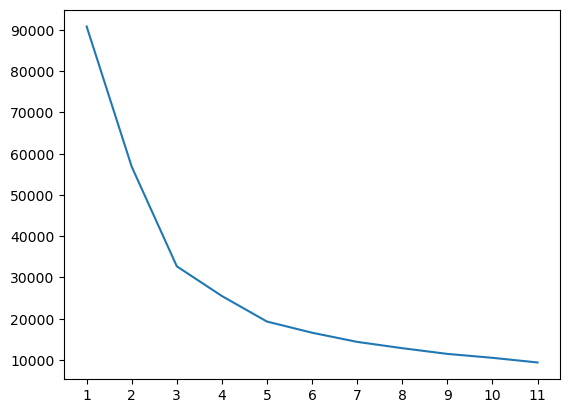

In [34]:
plt.plot(range(1, 12), wcss)
plt.xticks(range(1, 12))
plt.show()

In [32]:
### from the graph, n_clusters = 5
kmeans = KMeans(n_clusters = 5, init = 'k-means++')
y_labels_kmeans = kmeans.fit_predict(df_pca)

silhouette_score : 0.43880269602757505


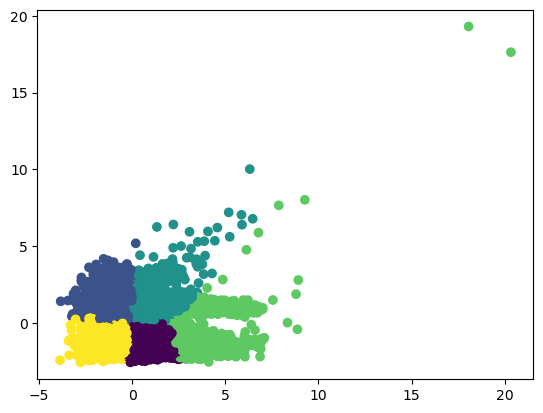

In [35]:
print(f"silhouette_score : {silhouette_score(df_pca, labels = y_labels_kmeans)}")
plt.scatter(df_pca[:, 0], df_pca[:, 1], c = y_labels_kmeans)

### 2. DBscan clustering

In [36]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [37]:
neigh = NearestNeighbors(n_neighbors = 5)
nbrs = neigh.fit(df_pca)
distances, indices = nbrs.kneighbors(df_pca)
distances = np.sort(distances[:, 4])

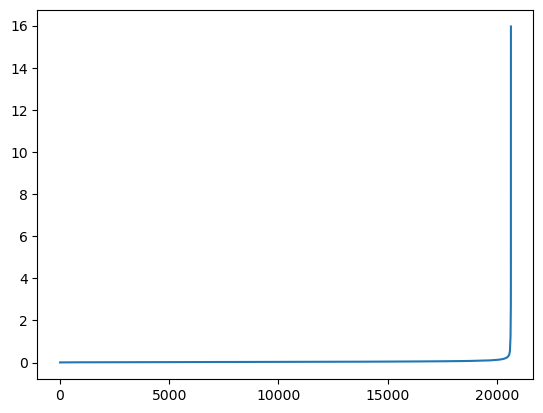

In [38]:
plt.plot(distances)

In [41]:
### eps = 0.2
db = DBSCAN(eps = 0.2)
y_labels_db = db.fit_predict(df_pca)

silhouette_score : -0.0725706739092499


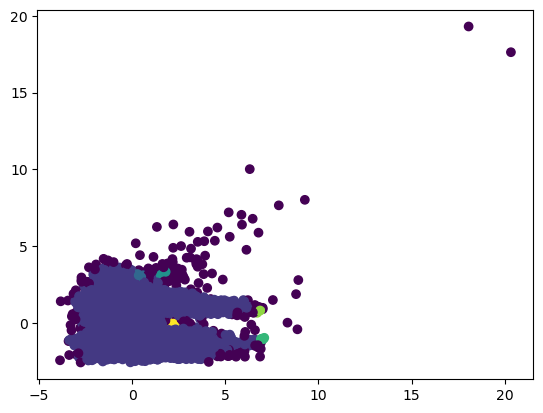

In [42]:
print(f"silhouette_score : {silhouette_score(df_pca, labels = y_labels_db)}")
plt.scatter(df_pca[:, 0], df_pca[:, 1], c = y_labels_db)

### 3. Hierarchal mean clustering

In [45]:
df_pca_hm = df_pca[:3000]

In [47]:
df_pca.shape

(20640, 2)

In [46]:
df_pca_hm.shape

(3000, 2)

Text(0, 0.5, 'euclidian distance')

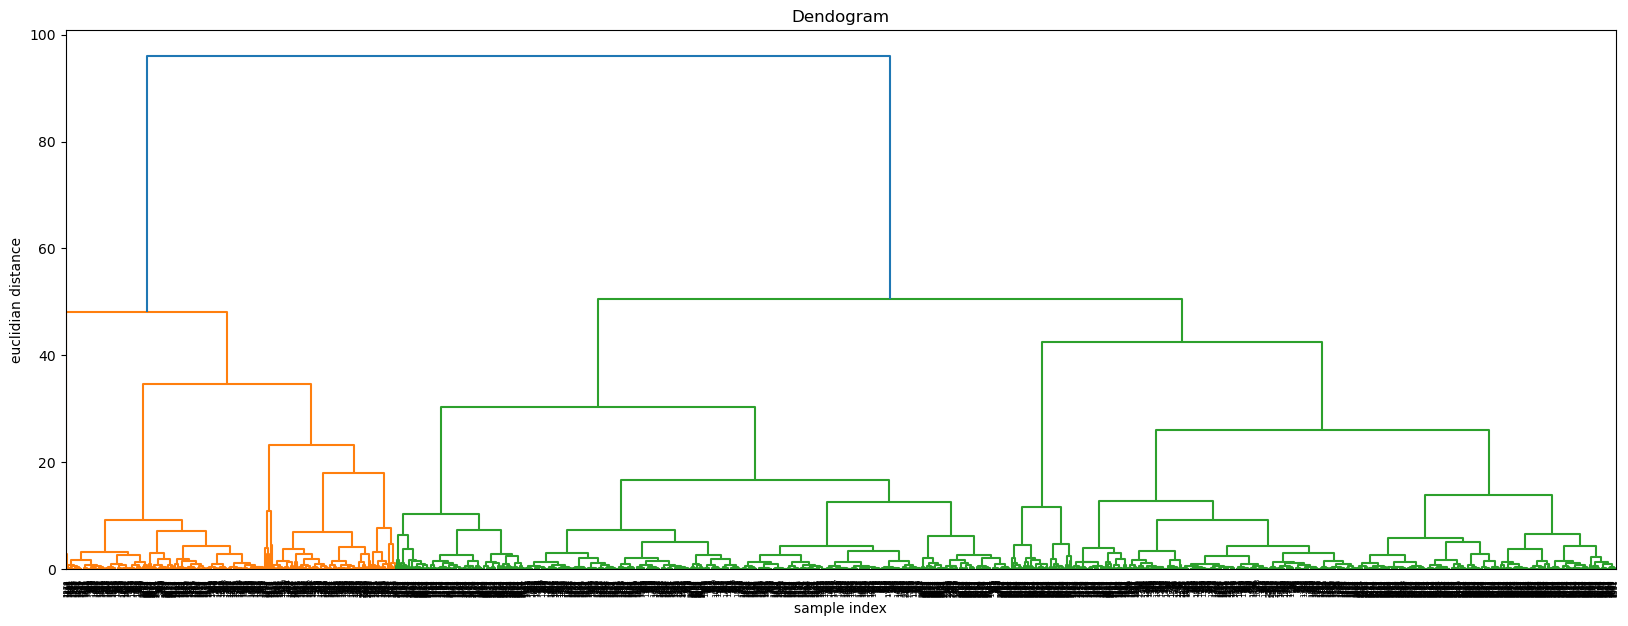

In [49]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sc
plt.figure(figsize=(20,7))
plt.title("Dendogram")
sc.dendrogram(sc.linkage(df_pca_hm, method = 'ward'))
plt.title('Dendogram')
plt.xlabel("sample index")
plt.ylabel("euclidian distance")

In [50]:
### from dendogram, clusters = 4
hm = AgglomerativeClustering(n_clusters = 4, linkage = 'ward')
y_labels_hm = hm.fit_predict(df_pca_hm)

silhouette_score : 0.3184251143059567


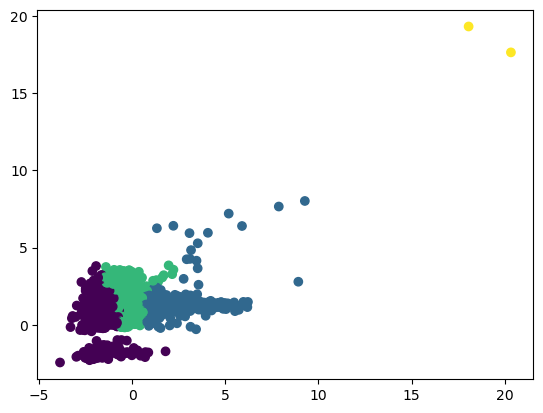

In [51]:
print(f"silhouette_score : {silhouette_score(df_pca_hm, labels = y_labels_hm)}")
plt.scatter(df_pca_hm[:, 0], df_pca_hm[:, 1], c = y_labels_hm)

### -------------Outliers--------------

In [52]:
def plot(df_pca, outliers) : 
    plt.figure(figsize = (10, 6))
    plt.subplot(1, 2, 1)
    plt.title('With Outliers')
    plt.scatter(df_pca[:, 0], df_pca[:, 1])
    plt.scatter(df_pca[outliers, 0], df_pca[outliers, 1], color = 'red')
    plt.subplot(1, 2, 2)
    plt.title('Original')
    plt.scatter(df_pca[:, 0], df_pca[:, 1])
    plt.show()

### 1. Isolation Forest

In [53]:
from sklearn.ensemble import IsolationForest
cif = IsolationForest(contamination = 'auto', random_state = 42)
cif.fit(df_pca)
scores = cif.score_samples(df_pca)
scores_sorted = np.sort(scores)

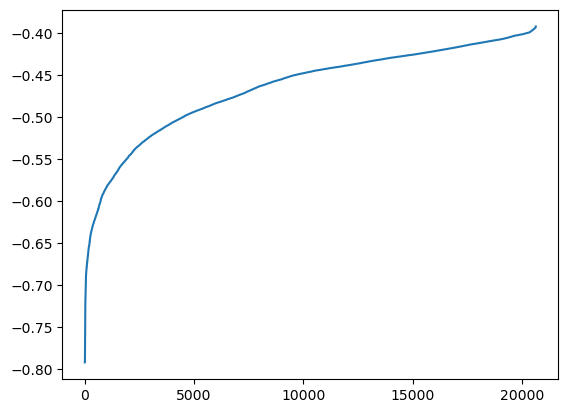

In [54]:
plt.plot(scores_sorted)

In [60]:
scores_threshold = np.where(scores < -0.62)
print(len(scores_threshold[0]))

477


In [62]:
### contamination from the plot = 0.03
cif = IsolationForest(contamination = 0.03)
predictions = cif.fit_predict(df_pca)
outliers = np.where(predictions < 0)

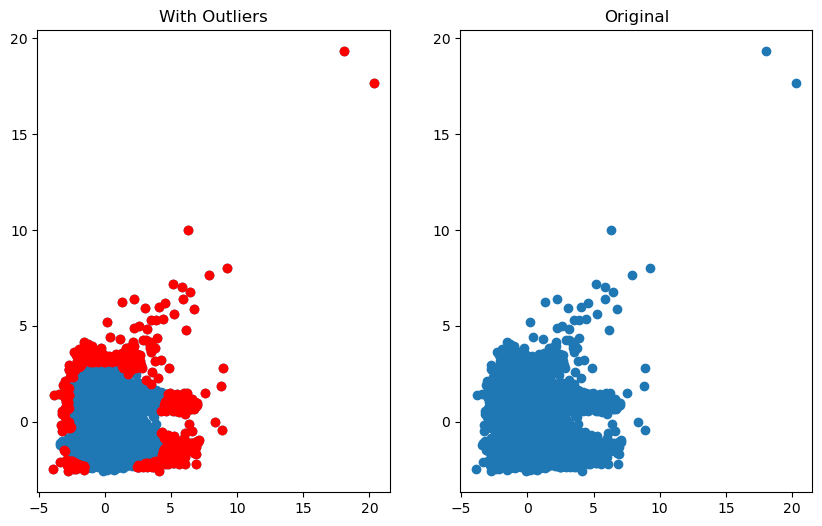

In [63]:
plot(df_pca, outliers)

### 2. LOF(Local Outliers)

In [68]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors = 5, algorithm = 'auto', leaf_size = 30)
predictions = lof.fit_predict(df_pca)
outliers = np.where(predictions < 1)

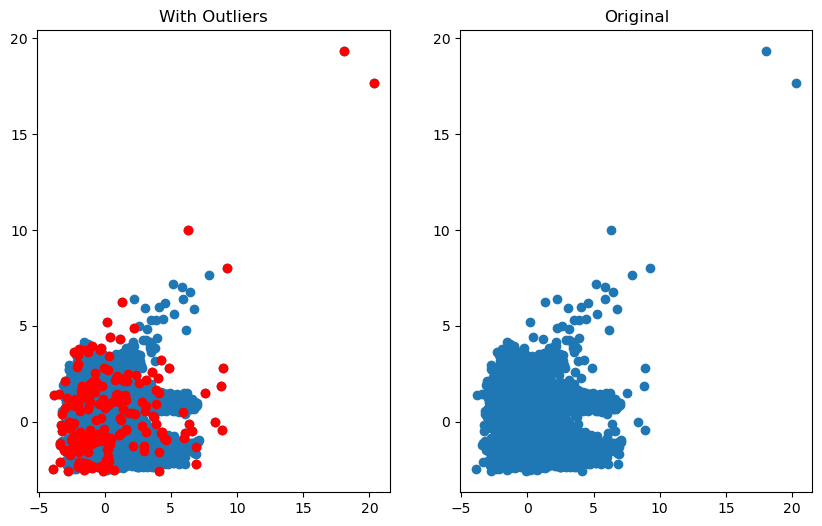

In [69]:
plot(df_pca, outliers)